## 0. Imports

In [502]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm
import pandas_ta as ta
import datetime
import itertools
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from xgboost import XGBRegressor, plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

## 1. Read data into Dataframe

In [2]:
df = pd.read_csv('../../long_short_local/raw_data/cleaned_data.csv')

In [505]:
df.head()

,Date,TEL_BIO,ADP_SYK,ON_MU,ROST_VFC,CDW_T,PAYX_RTX,APH_STE,NDSN_STE,CAH_NEM,CEG_NEM,DIS_NEM,IT_NEM,NRG_NEM,SCHW_NEM,TT_NEM
0,2022-02-23,0.239509,0.771140,0.663637,1.560298,9.729875,1.237427,0.326856,0.983616,0.781127,0.636250,2.170135,4.069952,0.537846,1.220489,2.195844
1,2022-02-24,0.234301,0.774126,0.689893,1.592246,10.004847,1.227451,0.326426,0.963968,0.784539,0.671616,2.273621,4.282290,0.570192,1.244242,2.280275
2,2022-02-25,0.223696,0.766083,0.707117,1.601182,10.073827,1.208059,0.322575,0.955513,0.796171,0.653839,2.236053,4.284883,0.557495,1.274335,2.292504
3,2022-02-28,0.225564,0.773484,0.706936,1.594907,9.877013,1.158270,0.315486,0.940690,0.813754,0.702244,2.277063,4.301050,0.569553,1.287397,2.339218
4,2022-03-01,0.217456,0.767553,0.693815,1.633461,9.768311,1.143246,0.311195,0.937899,0.763564,0.700168,2.143734,4.038225,0.527591,1.138470,2.216707


## 2. Prepare data

### 2.1 Add SMA (simple moving average) for 10, 20 and 60 days

In [3]:
# convert 'Date' column to datetime values
df['Date'] = pd.to_datetime(df['Date'].str[:10])

In [4]:
sma_list = [10, 20, 60]

for sma in sma_list:
    if sma == 10:
        sma_10_df_prep = pd.DataFrame(df['Date'])

        for ratio in df.columns:
            test_df = df[['Date', ratio]]
            sma10 = pd.DataFrame(ta.sma(test_df[ratio], length=10))
            loop_df = pd.concat([test_df, sma10], axis=1, ignore_index=False)
            loop_df.rename(columns={'SMA_10': f'{ratio}_SMA_10'}, inplace=True)
            sma_10_df_prep = pd.concat([sma_10_df_prep, loop_df], axis=1, ignore_index=False)
            sma_10_df = sma_10_df_prep.iloc[:, 3:]
    
    elif sma == 20:
        sma_20_df_prep = pd.DataFrame(df['Date'])

        for ratio in df.columns:
            test_df = df[['Date', ratio]]
            sma20 = pd.DataFrame(ta.sma(test_df[ratio], length=20))
            loop_df = pd.concat([test_df, sma20], axis=1, ignore_index=False)
            loop_df.rename(columns={'SMA_20': f'{ratio}_SMA_20'}, inplace=True)
            sma_20_df_prep = pd.concat([sma_20_df_prep, loop_df], axis=1, ignore_index=False)
            sma_20_df = sma_20_df_prep.iloc[:, 3:]
    
    else:
        sma_60_df_prep = pd.DataFrame(df['Date'])

        for ratio in df.columns:
            test_df = df[['Date', ratio]]
            sma60 = pd.DataFrame(ta.sma(test_df[ratio], length=60))
            loop_df = pd.concat([test_df, sma60], axis=1, ignore_index=False)
            loop_df.rename(columns={'SMA_60': f'{ratio}_SMA_60'}, inplace=True)
            sma_60_df_prep = pd.concat([sma_60_df_prep, loop_df], axis=1, ignore_index=False)
            sma_60_df = sma_60_df_prep.iloc[:, 3:]

### 2.2 Add RSI (relative strength index) for 14 days

In [31]:
rsi_14_df_prep = pd.DataFrame(df['Date'])

for ratio in df.columns:
    test_df = df[['Date', ratio]]
    rsi14 = pd.DataFrame(ta.rsi(test_df[ratio], length=14))
    loop_df = pd.concat([test_df, rsi14], axis=1, ignore_index=False)
    loop_df.rename(columns={'RSI_14': f'{ratio}_RSI_14'}, inplace=True)
    rsi_14_df_prep = pd.concat([rsi_14_df_prep, loop_df], axis=1, ignore_index=False)
    rsi_14_df = rsi_14_df_prep.iloc[:, 3:]

### 2.3 Concatenate all 4 DFs

In [319]:
sorted_df

,ADP_SYK,ADP_SYK_RSI_14,ADP_SYK_SMA_10,ADP_SYK_SMA_20,ADP_SYK_SMA_60,APH_STE,APH_STE_RSI_14,APH_STE_SMA_10,APH_STE_SMA_20,APH_STE_SMA_60,...,TEL_BIO,TEL_BIO_RSI_14,TEL_BIO_SMA_10,TEL_BIO_SMA_20,TEL_BIO_SMA_60,TT_NEM,TT_NEM_RSI_14,TT_NEM_SMA_10,TT_NEM_SMA_20,TT_NEM_SMA_60
Date,,,,,,,,,,,,,,,,,,,,,
2022-02-23,0.771140,NaN,NaN,NaN,NaN,0.326856,NaN,NaN,NaN,NaN,...,0.239509,NaN,NaN,NaN,NaN,2.195844,NaN,NaN,NaN,NaN
2022-02-24,0.774126,NaN,NaN,NaN,NaN,0.326426,NaN,NaN,NaN,NaN,...,0.234301,NaN,NaN,NaN,NaN,2.280275,NaN,NaN,NaN,NaN
2022-02-25,0.766083,NaN,NaN,NaN,NaN,0.322575,NaN,NaN,NaN,NaN,...,0.223696,NaN,NaN,NaN,NaN,2.292504,NaN,NaN,NaN,NaN
2022-02-28,0.773484,NaN,NaN,NaN,NaN,0.315486,NaN,NaN,NaN,NaN,...,0.225564,NaN,NaN,NaN,NaN,2.339218,NaN,NaN,NaN,NaN
2022-03-01,0.767553,NaN,NaN,NaN,NaN,0.311195,NaN,NaN,NaN,NaN,...,0.217456,NaN,NaN,NaN,NaN,2.216707,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-17,1.177302,71.370360,1.153486,1.129509,1.060523,0.376317,71.130987,0.370512,0.353187,0.326485,...,0.258362,68.161378,0.249195,0.242021,0.237775,3.706459,85.439464,3.517020,3.304354,2.498414
2022-08-18,1.181579,72.283491,1.157752,1.134131,1.065004,0.376562,71.244974,0.370902,0.356096,0.327684,...,0.263737,71.660623,0.250940,0.243577,0.238229,3.739306,86.005048,3.548923,3.358520,2.528126
2022-08-19,1.191070,74.246225,1.162304,1.138439,1.069676,0.377388,71.650973,0.372062,0.358917,0.328950,...,0.264347,72.036201,0.252804,0.245116,0.238679,3.760855,86.378857,3.580269,3.411108,2.558894


In [312]:
concat_10_20_df = pd.concat([sma_10_df, sma_20_df], axis=1)
concat_10_20_60_df = pd.concat([concat_10_20_df, sma_60_df], axis=1)
combined_df = pd.concat([concat_10_20_60_df, rsi_14_df], axis=1)
# remove duplicates of 'Date' column
dropped_date_df = combined_df.loc[:,~combined_df.columns.duplicated()]
dropped_date_df.set_index('Date', inplace=True)
# sort the ratios by column name
sorted_df = dropped_date_df.reindex(sorted(dropped_date_df.columns, reverse=False), axis=1)

In [316]:
test_plot_df = sorted_df[['ADP_SYK', 'ADP_SYK_SMA_10', 'ADP_SYK_SMA_20', 'ADP_SYK_SMA_60']]

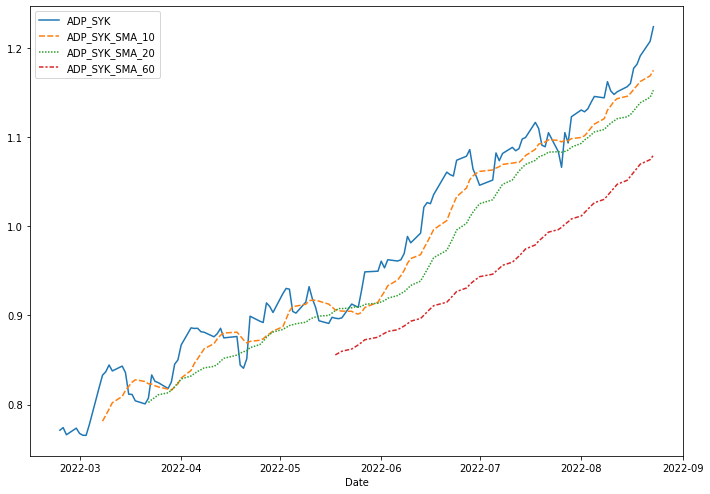

In [317]:
# test plot for the first ratio
dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dims)
sns.lineplot(data=test_plot_df.iloc[:, :5]);

- sorted_df contains all ratios with SMA for 10, 20, 60 days and RSI for 14 days. 
- We will load each time series to the XGBoost model separately
- But first, we need to create the features and labels

# Model test

### Prophet - Start

In [461]:
# reset index => 'Date' column becomes normal column in preparation for Prophet
prophet_df = ratio_df

In [462]:
prophet_df

,Date,ADP_SYK,ADP_SYK_RSI_14,ADP_SYK_SMA_10,ADP_SYK_SMA_20,ADP_SYK_SMA_60,5d_close_pct,5d_future_close,5d_future_close_pct,weekday_1,weekday_2,weekday_3,weekday_4
0,2022-02-23,0.771140,NaN,NaN,NaN,NaN,NaN,0.765541,NaN,0,1,0,0
1,2022-02-24,0.774126,NaN,NaN,NaN,NaN,NaN,0.765399,NaN,0,0,1,0
2,2022-02-25,0.766083,NaN,NaN,NaN,NaN,NaN,0.777620,NaN,0,0,0,1
3,2022-02-28,0.773484,NaN,NaN,NaN,NaN,NaN,0.819354,NaN,0,0,0,0
4,2022-03-01,0.767553,NaN,NaN,NaN,NaN,NaN,0.832825,NaN,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,2022-08-17,1.177302,71.370360,1.153486,1.129509,1.060523,0.022160,NaN,0.039511,0,1,0,0
122,2022-08-18,1.181579,72.283491,1.157752,1.134131,1.065004,0.029437,NaN,0.035748,0,0,1,0
123,2022-08-19,1.191070,74.246225,1.162304,1.138439,1.069676,0.034939,NaN,0.027495,0,0,0,1
124,2022-08-22,1.207346,77.224968,1.168640,1.144620,1.074647,0.043987,NaN,0.013643,0,0,0,0


In [330]:
# select first ratio for testing
#pr_first_ratio_df = prophet_df.iloc[:, :6]

In [480]:
# rename 'Date' and ratio column
pr_first_ratio_df = prophet_df.rename(columns={'5d_future_close': 'y', 'Date': 'ds'})

In [481]:
# fill NaNs
pr_first_ratio_df = pr_first_ratio_df.fillna(pr_first_ratio_df.median())

/var/folders/9c/wqkq2b6j16l2hg0gd5_m7sj00000gn/T/ipykernel_34565/722838502.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  pr_first_ratio_df = pr_first_ratio_df.fillna(pr_first_ratio_df.median())


In [482]:
pr_first_ratio_df.head()

,ds,ADP_SYK,ADP_SYK_RSI_14,ADP_SYK_SMA_10,ADP_SYK_SMA_20,ADP_SYK_SMA_60,5d_close_pct,y,5d_future_close_pct,weekday_1,weekday_2,weekday_3,weekday_4
0,2022-02-23,0.771140,66.931637,0.916992,0.924568,0.952728,0.017982,0.765541,0.019582,0,1,0,0
1,2022-02-24,0.774126,66.931637,0.916992,0.924568,0.952728,0.017982,0.765399,0.019582,0,0,1,0
2,2022-02-25,0.766083,66.931637,0.916992,0.924568,0.952728,0.017982,0.777620,0.019582,0,0,0,1
3,2022-02-28,0.773484,66.931637,0.916992,0.924568,0.952728,0.017982,0.819354,0.019582,0,0,0,0
4,2022-03-01,0.767553,66.931637,0.916992,0.924568,0.952728,0.017982,0.832825,0.019582,1,0,0,0


In [537]:
# generate train and test sets
train_size = int(0.85 * pr_first_ratio_df.shape[0])
train_set = pr_first_ratio_df[:train_size]
test_set = pr_first_ratio_df[train_size:] 

#### Baseline model

In [550]:
y_true_base = pr_first_ratio_df['y']
y_pred_base = pr_first_ratio_df['y'].shift(5)

y_pred_base = y_pred_base.iloc[5:]
y_true_base = y_true_base.iloc[5:]

print(f'R2: {r2_score(y_true_base, y_pred_base)}')

R2: 0.7001245471231394


#### Prophet model

In [484]:
proph = Prophet(growth='linear', 
                yearly_seasonality=True,
                daily_seasonality=True)

proph.add_regressor('ADP_SYK_RSI_14')
proph.add_regressor('ADP_SYK_SMA_10')
proph.add_regressor('ADP_SYK_SMA_20')
proph.add_regressor('ADP_SYK_SMA_60')

proph.fit(train_set)

Initial log joint probability = -2.04239


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       421.384   0.000341581       190.104           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166       423.567   5.02332e-05       155.904   2.959e-07       0.001      234  LS failed, Hessian reset 
     199       423.739   7.75343e-05       97.3853      0.7254      0.7254      271   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     232       423.767   6.06979e-05       161.947    3.18e-07       0.001      349  LS failed, Hessian reset 
     282       423.781    2.1821e-08       97.6892      0.1608           1      410   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [485]:
# create df that holds future values
future_df = proph.make_future_dataframe(periods=len(test_set),
                                        freq='D')

future_df.tail(1)

,ds
125,2022-08-15


In [486]:
# merge regressors
future_df = pd.concat([future_df,  pr_first_ratio_df.iloc[:, 2:]], axis=1)
future_df.head()

,ds,ADP_SYK_RSI_14,ADP_SYK_SMA_10,ADP_SYK_SMA_20,ADP_SYK_SMA_60,5d_close_pct,y,5d_future_close_pct,weekday_1,weekday_2,weekday_3,weekday_4
0,2022-02-23,66.931637,0.916992,0.924568,0.952728,0.017982,0.765541,0.019582,0,1,0,0
1,2022-02-24,66.931637,0.916992,0.924568,0.952728,0.017982,0.765399,0.019582,0,0,1,0
2,2022-02-25,66.931637,0.916992,0.924568,0.952728,0.017982,0.777620,0.019582,0,0,0,1
3,2022-02-28,66.931637,0.916992,0.924568,0.952728,0.017982,0.819354,0.019582,0,0,0,0
4,2022-03-01,66.931637,0.916992,0.924568,0.952728,0.017982,0.832825,0.019582,1,0,0,0


In [487]:
# forecast
forecast = proph.predict(future_df)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,ADP_SYK_RSI_14,ADP_SYK_RSI_14_lower,ADP_SYK_RSI_14_upper,ADP_SYK_SMA_10,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
121,2022-08-11,1.177389,1.059713,1.093849,1.177389,1.177389,-0.003723,-0.003723,-0.003723,-0.016808,...,-0.002022,-0.002022,-0.002022,0.025563,0.025563,0.025563,0.0,0.0,0.0,1.076687
122,2022-08-12,1.179887,1.048152,1.083221,1.179887,1.179887,-0.004359,-0.004359,-0.004359,-0.017129,...,-0.001451,-0.001451,-0.001451,0.014903,0.014903,0.014903,0.0,0.0,0.0,1.065890
123,2022-08-13,1.182385,1.042455,1.076471,1.182385,1.182385,-0.005726,-0.005726,-0.005726,-0.017471,...,0.004465,0.004465,0.004465,0.003657,0.003657,0.003657,0.0,0.0,0.0,1.059054
124,2022-08-14,1.184882,1.027646,1.060604,1.184882,1.184882,-0.007800,-0.007800,-0.007800,-0.017947,...,0.004465,0.004465,0.004465,-0.007982,-0.007982,-0.007982,0.0,0.0,0.0,1.044766
125,2022-08-15,1.187380,1.006047,1.040564,1.187380,1.187380,-0.009575,-0.009575,-0.009575,-0.018410,...,-0.002800,-0.002800,-0.002800,-0.019803,-0.019803,-0.019803,0.0,0.0,0.0,1.023198


In [488]:
proph_preds = forecast.yhat[train_size:].rename('prophet')

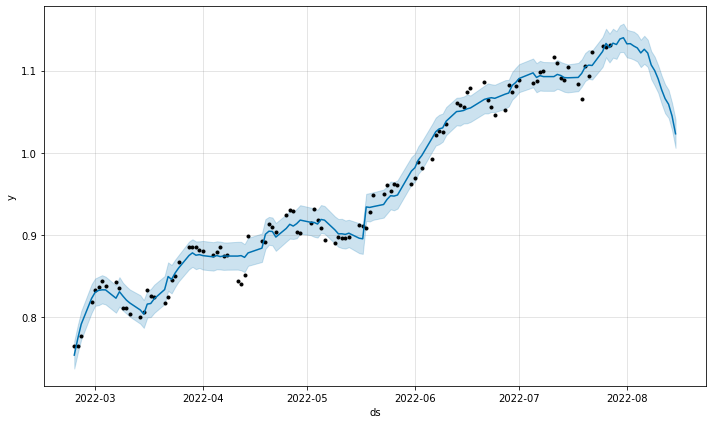

In [489]:
# visualise forecast
proph.plot(forecast);

In [490]:
# compute MAE and RMSE
print(round(mean_absolute_error(test_set['y'], proph_preds), 3))
print(round(mean_squared_error(test_set['y'], proph_preds), 3))

0.064
0.006


In [491]:
# compute MAPE
y_true, y_pred = np.array(test_set['y']), np.array(proph_preds)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [492]:
print(f'MAPE: {round(mape, 2)}')

MAPE: 6.13


In [493]:
# cross-validation
cv_df = cross_validation(proph,
                         horizon='20 days',
                         parallel='processes',
                         initial=20)

INFO:fbprophet:Making 14 forecasts with cutoffs between 2022-02-27 00:00:00 and 2022-07-07 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x1500f2c10>



Initial log joint probability = -119.977

Initial log joint probability = -130.174
Iteration  1. Log joint probability =    80.2278. Improved by 200.205.
Iteration  1. Log joint probability =     7.6093. Improved by 137.783.
Iteration  2. Log joint probability =    112.336. Improved by 32.108.
Iteration  2. Log joint probability =    10.8002. Improved by 3.19085.
Iteration  3. Log joint probability =    12.7566. Improved by 1.95648.
Iteration  3. Log joint probability =    146.513. Improved by 34.177.
Iteration  4. Log joint probability =    14.6741. Improved by 1.91743.
Iteration  4. Log joint probability =    148.718. Improved by 2.20563.

Initial log joint probability = -114.444
Iteration  5. Log joint probability =    16.5617. Improved by 1.88768.
Iteration  1. Log joint probability =    67.0128. Improved by 181.457.
Iteration  5. Log joint probability =    170.582. Improved by 21.8635.
Iteration  6. Log joint probability =    19.0572. Improved by 2.49545.

Initial log joint proba

INFO:fbprophet:n_changepoints greater than number of observations. Using 1.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Iteration  7. Log joint probability =    194.074. Improved by 21.9591.
Iteration  2. Log joint probability =     22.361. Improved by 6.69285.
Iteration  3. Log joint probability =     125.13. Improved by 25.8252.
Iteration  8. Log joint probability =    22.9955. Improved by 2.85713.
Iteration  8. Log joint probability =    208.759. Improved by 14.685.
Iteration  3. Log joint probability =     26.711. Improved by 4.35004.
Iteration  9. Log joint probability =    24.9166. Improved by 1.92104.
Iteration  9. Log joint probability =     209.19. Improved by 0.43017.
Iteration  4. Log joint probability =    159.996. Improved by 34.8663.
Iteration 10. Log joint probability =    209.208. Improved by 0.0182811.
Iteration 11. Log joint probability =    209.228. Improved by 0.0202963.
Iteration 10. Log joint probability =    27.1262. Improved by 2.20963.
Iteration  4. Log joint probability =    35.2396. Improved by 8.52857.
Iteration  5. Log joint probability =    186.324. Improved by 26.328.
Iter

INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Iteration 17. Log joint probability =     209.66. Improved by 0.0382038.
Iteration 15. Log joint probability =    36.3598. Improved by 0.67235.
Iteration  2. Log joint probability =    35.5059. Improved by 12.6339.
Iteration  2. Log joint probability =    83.4813. Improved by 28.5483.
Iteration 11. Log joint probability =    188.839. Improved by 0.0649282.
Iteration  8. Log joint probability =    60.7156. Improved by 3.45926.
Iteration  4. Log joint probability =    73.8365. Improved by 2.29921.

Initial log joint probability = -107.09
Iteration 16. Log joint probability =    39.3528. Improved by 2.99303.
Iteration 18. Log joint probability =    209.671. Improved by 0.0104139.
Iteration  3. Log joint probability =    44.3404. Improved by 8.83443.
Iteration  9. Log joint probability =    61.4482. Improved by 0.732664.
Iteration 12. Log joint probability =    189.016. Improved by 0.176823.
Iteration 10. Log joint probability =    61.5236. Improved by 0.0753693.
Iteration 19. Log joint pr

In [494]:
# evaluation
mae = round(mean_absolute_error(cv_df['y'], cv_df['yhat']), 2)
print(f'MAE: {round(mae, 2)}')
rmse = round(mean_squared_error(cv_df['y'], cv_df['yhat']), 2)
print(f'RMSE: {round(rmse, 2)}')
y_true, y_pred = np.array(cv_df['y']), np.array(cv_df['yhat'])
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'MAPE: {round(mape, 2)}')

MAE: 4.18
RMSE: 71.34
MAPE: 472.93


In [495]:
# hyperparameter tuning
param_grid = {'seasonality_prior_scale': [5, 10, 20],
              'changepoint_prior_scale': [0.01, 0.05, 0.1]
             }

grid = ParameterGrid(param_grid)

In [496]:
rmse = []

for params in grid:
    # build model
    proph = Prophet(growth='linear', 
                yearly_seasonality=True,
                daily_seasonality=True,
                seasonality_prior_scale = params['seasonality_prior_scale'],
                changepoint_prior_scale = params['changepoint_prior_scale'])

    proph.add_regressor('ADP_SYK_RSI_14')
    proph.add_regressor('ADP_SYK_SMA_10')
    proph.add_regressor('ADP_SYK_SMA_20')
    proph.add_regressor('ADP_SYK_SMA_60')

    proph.fit(train_set)
    # cross-val
    cv_df = cross_validation(proph,
                         horizon='20 days',
                         parallel='processes',
                         initial=20)
    
    # get results
    error = mean_squared_error(cv_df['y'], cv_df['yhat'])
    rmse.append(error)

INFO:fbprophet:Making 14 forecasts with cutoffs between 2022-02-27 00:00:00 and 2022-07-07 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x14f655820>


Initial log joint probability = -2.04239
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       418.687   0.000346244       526.699      0.2666           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     189       418.749   5.86465e-09       500.762      0.2325           1      234   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.



Initial log joint probability = -54.8054
Iteration  1. Log joint probability =    40.3999. Improved by 95.2052.
Iteration  2. Log joint probability =    56.6585. Improved by 16.2586.
Iteration  3. Log joint probability =    71.3532. Improved by 14.6948.
Iteration  4. Log joint probability =    74.0116. Improved by 2.65835.

Initial log joint probability = -71.8467
Iteration  5. Log joint probability =    95.5852. Improved by 21.5736.
Iteration  1. Log joint probability =    22.8765. Improved by 94.7232.

Initial log joint probability = -50.6412
Iteration  2. Log joint probability =    35.3884. Improved by 12.5119.
Iteration  6. Log joint probability =    104.548. Improved by 8.96286.
Iteration  1. Log joint probability =    67.0725. Improved by 117.714.
Iteration  3. Log joint probability =    44.4011. Improved by 9.01273.
Iteration  7. Log joint probability =    104.951. Improved by 0.403097.
Iteration  8. Log joint probability =    105.955. Improved by 1.00345.
Iteration  4. Log joi

INFO:fbprophet:n_changepoints greater than number of observations. Using 1.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Iteration 30. Log joint probability =    107.731. Improved by 0.000475445.
Iteration  8. Log joint probability =    185.431. Improved by 0.814736.
Iteration 16. Log joint probability =    90.4815. Improved by 0.0276248.
Iteration  1. Log joint probability =     55.201. Improved by 93.8893.
Iteration 31. Log joint probability =    107.732. Improved by 0.000438998.
Iteration 17. Log joint probability =    90.5028. Improved by 0.0212682.
Iteration  3. Log joint probability =      12.74. Improved by 1.97435.
Iteration 18. Log joint probability =    90.5168. Improved by 0.0139953.

Initial log joint probability = -56.1739
Iteration 32. Log joint probability =    107.732. Improved by 0.00074651.
Iteration  9. Log joint probability =    188.739. Improved by 3.30866.
Iteration 33. Log joint probability =    107.733. Improved by 0.000260438.
Iteration 19. Log joint probability =    90.5193. Improved by 0.0025517.

Initial log joint probability = -43.2867
Iteration 34. Log joint probability =   

INFO:fbprophet:Making 14 forecasts with cutoffs between 2022-02-27 00:00:00 and 2022-07-07 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x150e8eee0>


Initial log joint probability = -2.04239
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       418.515   1.47209e-09       510.684     0.06011     0.06011      122   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.



Initial log joint probability = -78.3724
Iteration  1. Log joint probability =    40.3626. Improved by 118.735.
Iteration  2. Log joint probability =    56.5489. Improved by 16.1862.

Initial log joint probability = -74.2082

Initial log joint probability = -62.2553
Iteration  3. Log joint probability =    71.5368. Improved by 14.988.
Iteration  1. Log joint probability =    67.0128. Improved by 141.221.
Iteration  4. Log joint probability =    73.2192. Improved by 1.68235.
Iteration  5. Log joint probability =    97.1594. Improved by 23.9402.
Iteration  1. Log joint probability =    54.9329. Improved by 117.188.
Iteration  2. Log joint probability =       99.1. Improved by 32.0872.
Iteration  2. Log joint probability =    82.6636. Improved by 27.7307.
Iteration  3. Log joint probability =    124.924. Improved by 25.8244.
Iteration  6. Log joint probability =    104.498. Improved by 7.33878.

Initial log joint probability = -95.4137
Iteration  3. Log joint probability =      99.33. Im

INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 1.


Iteration 31. Log joint probability =        109. Improved by 1.14913e-05.
Iteration  7. Log joint probability =    154.521. Improved by 0.18035.
Iteration 17. Log joint probability =    143.475. Improved by 0.0127351.
Iteration 32. Log joint probability =        109. Improved by 8.94705e-05.
Iteration  8. Log joint probability =     155.33. Improved by 0.809525.
Iteration 21. Log joint probability =    189.104. Improved by 0.00152556.
Iteration  1. Log joint probability =    80.2278. Improved by 159.969.
Iteration  9. Log joint probability =    88.5697. Improved by 2.23664.
Iteration 10. Log joint probability =    89.4627. Improved by 0.893017.
Iteration 18. Log joint probability =    143.477. Improved by 0.00291574.
Iteration  5. Log joint probability =    41.7759. Improved by 6.76523.
Iteration 33. Log joint probability =        109. Improved by 3.6068e-05.
Iteration  4. Log joint probability =    14.6741. Improved by 1.93378.
Iteration 22. Log joint probability =    189.105. Improv

INFO:fbprophet:Making 14 forecasts with cutoffs between 2022-02-27 00:00:00 and 2022-07-07 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x150e8c520>


Initial log joint probability = -2.04239
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       418.664   0.000180027       560.787      0.4975      0.4975      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     188        418.75   5.61638e-07       501.234   1.112e-09       0.001      266  LS failed, Hessian reset 
     199        418.75   6.56443e-08       482.269      0.9361      0.9361      281   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     222       418.751   9.41577e-09       497.597      0.7615      0.7615      310   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:n_changepoints greater than number of observations. Using 1.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.



Initial log joint probability = -152.132
Iteration  1. Log joint probability =    7.60229. Improved by 159.734.

Initial log joint probability = -136.017
Iteration  2. Log joint probability =    10.7679. Improved by 3.16561.
Iteration  1. Log joint probability =    15.6469. Improved by 151.664.
Iteration  3. Log joint probability =    12.7402. Improved by 1.97226.
Iteration  2. Log joint probability =    21.9902. Improved by 6.34325.
Iteration  4. Log joint probability =    14.6837. Improved by 1.94357.
Iteration  3. Log joint probability =    24.8887. Improved by 2.89854.
Iteration  5. Log joint probability =    16.5753. Improved by 1.89159.
Iteration  4. Log joint probability =    30.7661. Improved by 5.87741.

Initial log joint probability = -97.7753
Iteration  5. Log joint probability =    35.6761. Improved by 4.90997.
Iteration  6. Log joint probability =    18.7569. Improved by 2.18162.
Iteration  6. Log joint probability =    36.2318. Improved by 0.555683.
Iteration  7. Log joi

INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Iteration  6. Log joint probability =    110.109. Improved by 7.94366.
Iteration  7. Log joint probability =    110.203. Improved by 0.0935841.
Iteration 12. Log joint probability =      143.6. Improved by 0.0145277.
Iteration 18. Log joint probability =    40.7977. Improved by 1.67558.
Iteration 17. Log joint probability =    79.7107. Improved by 0.366741.
Iteration 10. Log joint probability =    188.359. Improved by 1.19084.
Iteration  4. Log joint probability =    146.806. Improved by 27.3893.
Iteration  8. Log joint probability =    110.253. Improved by 0.0503193.
Iteration  4. Log joint probability =    55.4003. Improved by 11.5364.
Iteration 13. Log joint probability =    143.615. Improved by 0.0147744.
Iteration  9. Log joint probability =    110.288. Improved by 0.0351579.
Iteration 11. Log joint probability =    188.691. Improved by 0.331755.
Iteration  2. Log joint probability =    111.812. Improved by 31.6196.
Iteration 10. Log joint probability =    110.332. Improved by 0.0

INFO:fbprophet:Making 14 forecasts with cutoffs between 2022-02-27 00:00:00 and 2022-07-07 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x150e8eee0>


Initial log joint probability = -2.04239
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       421.219   0.000590986       206.905           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        423.96   4.00565e-05       101.842       0.683       0.683      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     238       423.976   4.72953e-05        138.45    2.45e-07       0.001      323  LS failed, Hessian reset 
     291       423.983    1.2633e-07       94.7359   1.201e-09       0.001      427  LS failed, Hessian reset 
     298       423.983   6.94294e-09       92.7705      0.3092      0.3092      435   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance

Initial log joint probability = -78.9242
Iteration  1. Log joint probability =     55.201. Imp

INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Iteration  6. Log joint probability =    49.3581. Improved by 7.95604.
Iteration  6. Log joint probability =    140.711. Improved by 15.0336.

Initial log joint probability = -85.3847
Iteration  7. Log joint probability =    142.874. Improved by 2.16277.
Iteration  3. Log joint probability =    127.594. Improved by 26.7219.
Iteration  8. Log joint probability =    143.105. Improved by 0.231105.
Iteration  1. Log joint probability =    40.3999. Improved by 125.785.
Iteration  7. Log joint probability =    52.3339. Improved by 2.97579.
Iteration  4. Log joint probability =    155.104. Improved by 27.5107.
Iteration  9. Log joint probability =    143.113. Improved by 0.00778246.

Initial log joint probability = -92.7694
Iteration 10. Log joint probability =    143.158. Improved by 0.0447435.

Initial log joint probability = -106.607
Iteration  8. Log joint probability =    54.1568. Improved by 1.8229.
Iteration 11. Log joint probability =    143.224. Improved by 0.0661884.
Iteration  1. L

INFO:fbprophet:n_changepoints greater than number of observations. Using 1.


Iteration  1. Log joint probability =    44.1256. Improved by 127.648.
Iteration 10. Log joint probability =    188.536. Improved by 0.231344.
Iteration  6. Log joint probability =    104.576. Improved by 8.98604.
Iteration 17. Log joint probability =    61.0792. Improved by 0.014354.
Iteration  6. Log joint probability =    72.2549. Improved by 11.0175.
Iteration  5. Log joint probability =    16.4336. Improved by 1.82558.
Iteration 24. Log joint probability =    143.384. Improved by 0.00378836.
Iteration 25. Log joint probability =    143.385. Improved by 0.00130234.
Iteration  3. Log joint probability =    146.848. Improved by 34.2594.
Iteration 11. Log joint probability =     188.62. Improved by 0.0838561.
Iteration 26. Log joint probability =    143.388. Improved by 0.00315174.
Iteration 18. Log joint probability =    61.0863. Improved by 0.00715788.
Iteration  7. Log joint probability =    106.238. Improved by 1.66191.
Iteration  2. Log joint probability =    95.4662. Improved by

INFO:fbprophet:Making 14 forecasts with cutoffs between 2022-02-27 00:00:00 and 2022-07-07 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x14f5cd940>


Initial log joint probability = -2.04239
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       421.384   0.000341581       190.104           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166       423.567   5.02332e-05       155.904   2.959e-07       0.001      234  LS failed, Hessian reset 
     199       423.739   7.75343e-05       97.3853      0.7254      0.7254      271   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     232       423.767   6.06979e-05       161.947    3.18e-07       0.001      349  LS failed, Hessian reset 
     282       423.781    2.1821e-08       97.6892      0.1608           1      410   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.



Initial log joint probability = -123.716
Iteration  1. Log joint probability =    15.6681. Improved by 139.384.

Initial log joint probability = -102.491
Iteration  2. Log joint probability =     22.361. Improved by 6.69285.
Iteration  1. Log joint probability =    54.9329. Improved by 157.424.
Iteration  3. Log joint probability =     26.711. Improved by 4.35004.
Iteration  2. Log joint probability =    83.4813. Improved by 28.5483.
Iteration  4. Log joint probability =    35.2396. Improved by 8.52857.

Initial log joint probability = -116.336
Iteration  3. Log joint probability =    99.7402. Improved by 16.259.
Iteration  5. Log joint probability =    41.8905. Improved by 6.65095.
Iteration  1. Log joint probability =     22.872. Improved by 139.208.
Iteration  4. Log joint probability =     113.04. Improved by 13.3.
Iteration  6. Log joint probability =    49.8911. Improved by 8.00058.
Iteration  2. Log joint probability =    35.5059. Improved by 12.6339.
Iteration  3. Log joint pr

INFO:fbprophet:n_changepoints greater than number of observations. Using 1.


Iteration 44. Log joint probability =    61.5457. Improved by 1.1695e-07.
Iteration  8. Log joint probability =    86.7269. Improved by 9.10132.
Iteration 45. Log joint probability =    61.5457. Improved by 2.21626e-08.
Iteration 46. Log joint probability =    61.5457. Improved by 8.98669e-08.
Iteration 18. Log joint probability =    143.471. Improved by 0.0230425.
Iteration 47. Log joint probability =    61.5457. Improved by 4.51959e-09.
Iteration 19. Log joint probability =    143.483. Improved by 0.0113382.
Iteration  9. Log joint probability =    89.0005. Improved by 2.27359.
Iteration 10. Log joint probability =    90.6045. Improved by 1.60396.
Iteration 20. Log joint probability =    143.483. Improved by 0.000385523.
Iteration  1. Log joint probability =    41.7892. Improved by 148.879.
Iteration  6. Log joint probability =    104.521. Improved by 7.35615.
Iteration  3. Log joint probability =    12.7566. Improved by 1.95648.

Initial log joint probability = -119.977
Iteration  2

INFO:fbprophet:Making 14 forecasts with cutoffs between 2022-02-27 00:00:00 and 2022-07-07 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x150c421f0>


Initial log joint probability = -2.04239
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       421.272     0.0122653       707.158           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       423.985   0.000129019       109.138      0.5957      0.5957      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     228       424.076   0.000308088       136.221    2.82e-06       0.001      302  LS failed, Hessian reset 
     296       424.123    6.7383e-09       102.443      0.3077           1      393   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 1.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.



Initial log joint probability = -147.283
Iteration  1. Log joint probability =    15.6469. Improved by 162.93.
Iteration  2. Log joint probability =     22.219. Improved by 6.57208.
Iteration  3. Log joint probability =    24.8893. Improved by 2.67032.
Iteration  4. Log joint probability =    30.9963. Improved by 6.10696.

Initial log joint probability = -153.741
Iteration  5. Log joint probability =    35.6754. Improved by 4.6791.
Iteration  1. Log joint probability =    7.60229. Improved by 161.343.
Iteration  6. Log joint probability =    36.6382. Improved by 0.962837.
Iteration  7. Log joint probability =    52.3961. Improved by 15.7579.

Initial log joint probability = -132.519
Iteration  2. Log joint probability =    10.8006. Improved by 3.1983.
Iteration  8. Log joint probability =    57.6022. Improved by 5.20606.
Iteration  3. Log joint probability =    12.7565. Improved by 1.95591.
Iteration  1. Log joint probability =    40.3506. Improved by 172.869.
Iteration  9. Log joint 

INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Iteration  9. Log joint probability =    110.431. Improved by 0.02263.
Iteration 10. Log joint probability =    110.457. Improved by 0.0257061.
Iteration 11. Log joint probability =    110.484. Improved by 0.027492.
Iteration  5. Log joint probability =    131.752. Improved by 17.644.

Initial log joint probability = -143.544
Iteration 16. Log joint probability =    66.7523. Improved by 0.319585.
Iteration  2. Log joint probability =    35.4848. Improved by 12.6144.
Iteration 11. Log joint probability =    27.8404. Improved by 1.93432.
Iteration 12. Log joint probability =    110.509. Improved by 0.024457.
Iteration 13. Log joint probability =    110.512. Improved by 0.0031186.

Initial log joint probability = -130.657
Iteration 14. Log joint probability =    110.525. Improved by 0.0132335.
Iteration 15. Log joint probability =    110.529. Improved by 0.00409551.
Iteration 17. Log joint probability =    66.7639. Improved by 0.0115273.
Iteration  1. Log joint probability =    80.1925. I

INFO:fbprophet:Making 14 forecasts with cutoffs between 2022-02-27 00:00:00 and 2022-07-07 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x1500ccd60>


Initial log joint probability = -2.04239
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       422.651    0.00148072       288.032      0.5032           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       424.137    0.00123775       115.602           1           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       424.432   5.59639e-05       79.6225      0.2807      0.2807      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       426.774   0.000266669       59.5529      0.9896      0.9896      443   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       427.013   3.88939e-06       46.6572           1           1      561   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 1.


Iteration  6. Log joint probability =    140.729. Improved by 15.0437.
Iteration  2. Log joint probability =     112.64. Improved by 32.2923.
Iteration  3. Log joint probability =     26.855. Improved by 4.52543.
Iteration  6. Log joint probability =    104.579. Improved by 8.98231.
Iteration  2. Log joint probability =    10.8024. Improved by 3.16529.
Iteration  1. Log joint probability =    67.0725. Improved by 175.278.
Iteration  7. Log joint probability =    143.152. Improved by 2.42318.
Iteration  5. Log joint probability =    61.2782. Improved by 5.8702.
Iteration  3. Log joint probability =    12.7583. Improved by 1.95595.

Initial log joint probability = -100.851
Iteration  7. Log joint probability =    106.326. Improved by 1.74709.
Iteration  6. Log joint probability =    72.2583. Improved by 10.9802.
Iteration  2. Log joint probability =    100.897. Improved by 33.8246.
Iteration  8. Log joint probability =    107.322. Improved by 0.99537.
Iteration  9. Log joint probability 

INFO:fbprophet:Making 14 forecasts with cutoffs between 2022-02-27 00:00:00 and 2022-07-07 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x150c63610>


Initial log joint probability = -2.04239
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       422.484    0.00201532       219.819           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        423.99    0.00427121       308.642           1           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       424.458    0.00070783       79.0928      0.3203      0.9621      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        425.64   6.21858e-05        112.11        0.93        0.93      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        426.06   0.000737794         131.3           1           1      559   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:n_changepoints greater than number of observations. Using 1.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.



Initial log joint probability = -130.867
Iteration  1. Log joint probability =     7.6093. Improved by 138.477.

Initial log joint probability = -128.568
Iteration  2. Log joint probability =    10.8042. Improved by 3.19493.
Iteration  1. Log joint probability =    15.6681. Improved by 144.236.
Iteration  3. Log joint probability =    12.7587. Improved by 1.95443.

Initial log joint probability = -125.347
Iteration  2. Log joint probability =    22.3895. Improved by 6.72139.
Iteration  4. Log joint probability =    14.6741. Improved by 1.91539.

Initial log joint probability = -131.773
Iteration  3. Log joint probability =    26.7113. Improved by 4.32176.
Iteration  1. Log joint probability =     22.872. Improved by 148.219.
Iteration  5. Log joint probability =    16.5638. Improved by 1.88973.
Iteration  4. Log joint probability =    35.2682. Improved by 8.55689.

Initial log joint probability = -124.418
Iteration  6. Log joint probability =    19.0588. Improved by 2.49502.
Iteration

INFO:fbprophet:n_changepoints greater than number of observations. Using 19.


Iteration  3. Log joint probability =    71.5378. Improved by 14.6395.
Iteration 10. Log joint probability =    61.8562. Improved by 0.32625.
Iteration 11. Log joint probability =    29.0364. Improved by 1.90526.
Iteration  1. Log joint probability =    54.9329. Improved by 174.753.
Iteration  8. Log joint probability =    86.7134. Improved by 9.06362.
Iteration 11. Log joint probability =    61.8588. Improved by 0.00265167.
Iteration  6. Log joint probability =    188.311. Improved by 1.9702.
Iteration  3. Log joint probability =    146.512. Improved by 34.1251.
Iteration  5. Log joint probability =    154.234. Improved by 7.70586.
Iteration  7. Log joint probability =    188.559. Improved by 0.247751.
Iteration  2. Log joint probability =    83.5837. Improved by 28.6507.
Iteration  4. Log joint probability =    73.9092. Improved by 2.3714.
Iteration  9. Log joint probability =    88.9857. Improved by 2.27237.
Iteration 12. Log joint probability =    30.9297. Improved by 1.89323.
Iter

INFO:fbprophet:Making 14 forecasts with cutoffs between 2022-02-27 00:00:00 and 2022-07-07 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x150c425b0>


Initial log joint probability = -2.04239
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        422.31    0.00113217        172.98           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199         424.1   0.000954853       180.908           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       424.558     0.0137745       648.996           1           1      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       426.114   0.000347267       106.546      0.6615      0.6615      455   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     440       426.332   6.21206e-05         134.7   5.693e-07       0.001      537  LS failed, Hessian reset 
     499       426.434   0.000769181    

INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.



Initial log joint probability = -152.135
Iteration  1. Log joint probability =    15.6469. Improved by 167.782.
Iteration  2. Log joint probability =    22.2476. Improved by 6.60064.
Iteration  3. Log joint probability =    24.8901. Improved by 2.64255.

Initial log joint probability = -148.914
Iteration  4. Log joint probability =    31.0265. Improved by 6.13641.

Initial log joint probability = -155.34
Iteration  1. Log joint probability =    22.8704. Improved by 171.785.
Iteration  5. Log joint probability =    35.6745. Improved by 4.648.
Iteration  6. Log joint probability =    36.6136. Improved by 0.939138.
Iteration  2. Log joint probability =    35.4981. Improved by 12.6277.
Iteration  1. Log joint probability =    66.9808. Improved by 222.321.
Iteration  7. Log joint probability =    52.3709. Improved by 15.7573.
Iteration  3. Log joint probability =    44.2226. Improved by 8.72448.

Initial log joint probability = -143.387
Iteration  8. Log joint probability =    57.4574. Imp

INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 1.


Iteration  3. Log joint probability =    12.7586. Improved by 1.95387.
Iteration 15. Log joint probability =    91.7054. Improved by 0.12007.
Iteration 15. Log joint probability =    71.9153. Improved by 0.0127439.
Iteration  6. Log joint probability =    142.421. Improved by 10.6339.
Iteration  4. Log joint probability =    86.3193. Improved by 14.9135.
Iteration  9. Log joint probability =    188.583. Improved by 0.018691.
Iteration 16. Log joint probability =    91.7319. Improved by 0.0265288.
Iteration 17. Log joint probability =    91.7364. Improved by 0.00454785.
Iteration  1. Log joint probability =    40.8497. Improved by 188.835.
Iteration 18. Log joint probability =    91.7399. Improved by 0.0034898.
Iteration 19. Log joint probability =    91.7439. Improved by 0.00391701.
Iteration 20. Log joint probability =    91.7473. Improved by 0.00348394.
Iteration  4. Log joint probability =    14.6837. Improved by 1.92518.
Iteration 16. Log joint probability =    77.8225. Improved by

In [497]:
# best parameters
best_params = grid[np.argmin(rmse)]
print(best_params)

{'seasonality_prior_scale': 5, 'changepoint_prior_scale': 0.05}


In [498]:
# final model
proph = Prophet(growth='linear', 
            yearly_seasonality=True,
            daily_seasonality=True,
            seasonality_prior_scale = best_params['seasonality_prior_scale'],
            changepoint_prior_scale = best_params['changepoint_prior_scale'])

proph.add_regressor('ADP_SYK_RSI_14')
proph.add_regressor('ADP_SYK_SMA_10')
proph.add_regressor('ADP_SYK_SMA_20')
proph.add_regressor('ADP_SYK_SMA_60')

proph.fit(train_set)

Initial log joint probability = -2.04239


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       421.219   0.000590986       206.905           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        423.96   4.00565e-05       101.842       0.683       0.683      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     238       423.976   4.72953e-05        138.45    2.45e-07       0.001      323  LS failed, Hessian reset 
     291       423.983    1.2633e-07       94.7359   1.201e-09       0.001      427  LS failed, Hessian reset 
     298       423.983   6.94294e-09       92.7705      0.3092      0.3092      435   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


In [499]:
# create future dataframe
future_df = proph.make_future_dataframe(periods=len(test_set),
                                        freq='D')
# merge regressors
future_df = pd.concat([future_df,  pr_first_ratio_df.iloc[:, 2:]], axis=1)
future_df.head()
future_df.tail(1)

,ds,ADP_SYK_RSI_14,ADP_SYK_SMA_10,ADP_SYK_SMA_20,ADP_SYK_SMA_60,5d_close_pct,y,5d_future_close_pct,weekday_1,weekday_2,weekday_3,weekday_4
125,2022-08-15,79.774497,1.174809,1.152509,1.079578,0.054957,0.932185,0.0,1,0,0,0


In [500]:
# forecast
forecast = proph.predict(future_df)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,ADP_SYK_RSI_14,ADP_SYK_RSI_14_lower,ADP_SYK_RSI_14_upper,ADP_SYK_SMA_10,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
121,2022-08-11,1.176998,1.040080,1.073483,1.176998,1.176998,-0.003763,-0.003763,-0.003763,-0.018438,...,-0.002213,-0.002213,-0.002213,0.008223,0.008223,0.008223,0.0,0.0,0.0,1.056292
122,2022-08-12,1.179499,1.027104,1.061224,1.179499,1.179499,-0.004406,-0.004406,-0.004406,-0.018789,...,-0.001684,-0.001684,-0.001684,-0.003591,-0.003591,-0.003591,0.0,0.0,0.0,1.044342
123,2022-08-13,1.182000,1.019061,1.054314,1.182000,1.182000,-0.005787,-0.005787,-0.005787,-0.019165,...,0.004919,0.004919,0.004919,-0.015803,-0.015803,-0.015803,0.0,0.0,0.0,1.037257
124,2022-08-14,1.184501,1.005083,1.039045,1.184501,1.184501,-0.007883,-0.007883,-0.007883,-0.019687,...,0.004919,0.004919,0.004919,-0.028194,-0.028194,-0.028194,0.0,0.0,0.0,1.022250
125,2022-08-15,1.187002,0.983354,1.017053,1.187002,1.187002,-0.009678,-0.009678,-0.009678,-0.020195,...,-0.002995,-0.002995,-0.002995,-0.040524,-0.040524,-0.040524,0.0,0.0,0.0,0.999575


In [501]:
# extract predictions
proph_preds_tuned = forecast.yhat[train_size:].rename('prophet_tuned')
proph_preds_tuned.index = test_set['ds']

⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️

We will now feed the tuned predicitions into the XGBoost model!

### Prophet - End

### XGBoost - Start

In [636]:
# xgboost preparation
# extract prophet variables
proph_variables = forecast.loc[:, ['ds', 'trend', 'ADP_SYK_RSI_14', 'ADP_SYK_SMA_10', 'ADP_SYK_SMA_20', 'ADP_SYK_SMA_60',
                                   'daily', 'weekly']]
# extract variables from original df
weekdays_df = pr_first_ratio_df.loc[:, ['weekday_1', 'weekday_2', 'weekday_3', 'weekday_4']]

xgb_df_prep = pd.concat([weekdays_df, proph_variables], axis=1)
xgb_df = pd.concat([xgb_df_prep, pr_first_ratio_df['y']], axis=1)
xgb_df['y'] = xgb_df['y'].fillna(xgb_df['y'].median())
xgb_df.head()

,weekday_1,weekday_2,weekday_3,weekday_4,ds,trend,ADP_SYK_RSI_14,ADP_SYK_SMA_10,ADP_SYK_SMA_20,ADP_SYK_SMA_60,daily,weekly,y
0,0,1,0,0,2022-02-23,0.754344,-0.000639,0.001056,0.000301,-0.005216,-0.039352,-0.001747,0.932185
1,0,0,1,0,2022-02-24,0.756845,-0.000639,0.001056,0.000301,-0.005216,-0.039352,-0.002213,0.765399
2,0,0,0,1,2022-02-25,0.759346,-0.000639,0.001056,0.000301,-0.005216,-0.039352,-0.001684,0.777620
3,0,0,0,0,2022-02-28,0.766849,-0.000639,0.001056,0.000301,-0.005216,-0.039352,-0.002995,0.819354
4,1,0,0,0,2022-03-01,0.769350,-0.000639,0.001056,0.000301,-0.005216,-0.039352,-0.001199,0.832825


In [637]:
# generate train and test sets
train_size = int(0.85 * xgb_df.shape[0])
train_set = xgb_df[:train_size]
test_set = xgb_df[train_size:] 

In [638]:
# create X and y
y_train = train_set.y
y_test = test_set.y

X_train = train_set.drop(columns=['y', 'ds'], axis=1)
X_test = test_set.drop(columns=['y', 'ds'], axis=1)

In [639]:
# xgboost model
xgb_model = XGBRegressor(learning_rate=0.1,
              max_depth=3,
              colsample_bytree=1,
              subsample=1,
              min_child_weight=1,
              gamma=1,
              eval_metric='rmse',
              objective='reg:squarederror')

In [640]:
# forecasting and visualisation
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eval_metric='rmse', gamma=1, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [646]:
xgb_preds = pd.Series(xgb_model.predict(X_test), name='XGBoost')
xgb_preds.index = test_set.ds

In [647]:
train_set.index = xgb_df[:train_size].ds
test_set.index = xgb_df[train_size:].ds

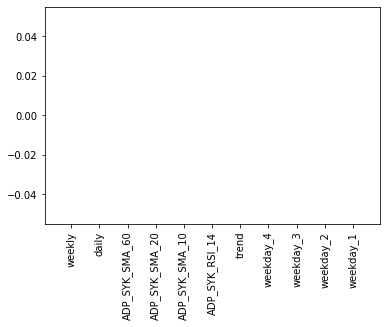

In [661]:
# feature importances 
importances = xgb_model.feature_importances_
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))
labels = np.array(feature_names)[sorted_index]
plt.bar(x, importances[sorted_index], tick_label=labels)
plt.xticks(rotation=90)
plt.show()

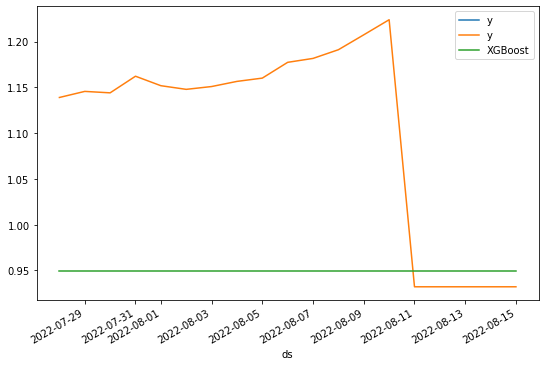

In [656]:
# visualisation
train_set.y['2022-07-28':].plot(figsize=(9, 6), legend=True)
test_set.y.plot(legend=True)
xgb_preds.plot(legend=True);

In [658]:
# evaluation
# mae and rmse
print(round(mean_absolute_error(test_set['y'], xgb_preds), 3))
print(round(mean_squared_error(test_set['y'], xgb_preds), 3))

# compute MAPE
y_true, y_pred = np.array(test_set['y']), np.array(xgb_preds)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(mape)

0.165
0.036
14.215516995824768


In [455]:
ratio_df[['Date', 'ADP_SYK', '5d_future_close', '5d_future_close_pct']].head(16)

,Date,ADP_SYK,5d_future_close,5d_future_close_pct
0,2022-02-23,0.771140,0.765541,NaN
1,2022-02-24,0.774126,0.765399,NaN
2,2022-02-25,0.766083,0.777620,NaN
3,2022-02-28,0.773484,0.819354,NaN
4,2022-03-01,0.767553,0.832825,NaN
5,2022-03-02,0.765541,0.836789,0.093068
6,2022-03-03,0.765399,0.844340,0.103137
7,2022-03-04,0.777620,0.837656,0.077204
8,2022-03-07,0.819354,0.843098,0.028978
9,2022-03-08,0.832825,0.835860,0.003644


In [187]:
ratio_df = sorted_df.iloc[:, :5]

In [451]:
# add price features
# the new column contains the %age change of each day compared to the prior 5 days
ratio_df['5d_close_pct'] = ratio_df['ADP_SYK'].pct_change(5)

In [453]:
ratio_df['5d_future_close'] = ratio_df['ADP_SYK'].shift(-5)

In [454]:
ratio_df['5d_future_close_pct'] = ratio_df['5d_future_close'].pct_change(5)

In [191]:
# add datetime features and concatenate with ratio_df
days_of_week = pd.get_dummies(ratio_df.index.dayofweek, prefix='weekday', drop_first=True)
ratio_df = pd.concat([ratio_df.reset_index(), days_of_week], axis=1, ignore_index=False)

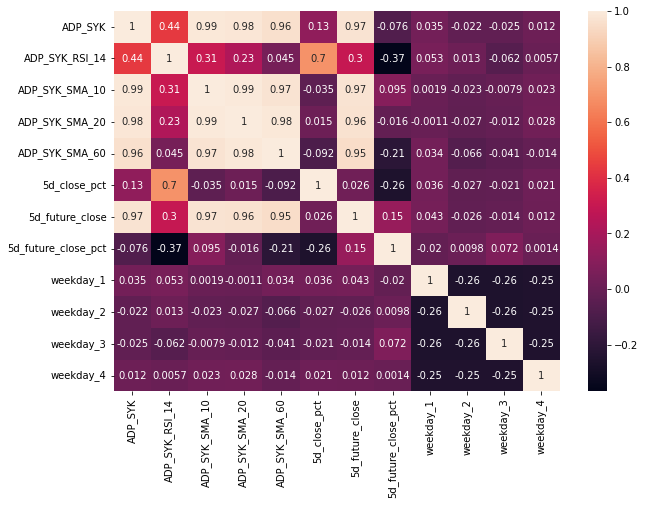

In [192]:
corr1 = ratio_df.corr()
dims = (10, 7)
fig, ax = plt.subplots(figsize=dims)
sns.heatmap(corr1, annot=True, fmt='.2g');

In [247]:
# extract features for modelling
feature_names = ['5d_close_pct', 'ADP_SYK_SMA_10', 'ADP_SYK_SMA_20', 'ADP_SYK_SMA_60', 'ADP_SYK_RSI_14', 
                 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4']
features = ratio_df[feature_names]
targets = ratio_df['5d_future_close_pct']

In [197]:
feature_target_df = pd.concat([ratio_df[feature_names], ratio_df['5d_future_close_pct']], axis=1)

In [250]:
# make train and test sets
#linear_features = sm.add_constant(features)
linear_features = features.fillna(features.median())
target_median = targets.median()
targets.fillna(target_median, inplace=True)

train_size = int(0.85 * targets.shape[0])
X_train = linear_features[:train_size]
y_train = targets[:train_size]
X_test = linear_features[train_size:]
y_test = targets[train_size:]

In [254]:
# build the XGBoost model
xgb_reg = XGBRegressor(booster='gbtree',
                       objective='reg:squarederror',
                       max_depth=3,
                       n_estimators=100,
                       learning_rate=0.1,
                       n_jobs=-1,
                       random_state=2)

In [255]:
# fit the model
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=-1,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=2, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

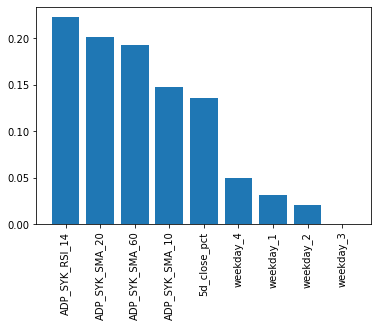

In [259]:
# check feature importances
importances = xgb_reg.feature_importances_
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))
labels = np.array(feature_names)[sorted_index]
plt.bar(x, importances[sorted_index], tick_label=labels)
plt.xticks(rotation=90)
plt.show()

In [278]:
# make a 5 day prediction
y_pred = pd.Series(xgb_reg.predict(X_test), name='XGBoost')
y_pred.index = ratio_df.Date[train_size:]

In [279]:
y_pred

Date
2022-07-28    0.023331
2022-07-29    0.023898
2022-08-01    0.019450
2022-08-02    0.018176
2022-08-03    0.013803
2022-08-04    0.019902
2022-08-05    0.022547
2022-08-08    0.028720
2022-08-09    0.003909
2022-08-10    0.015435
2022-08-11    0.023331
2022-08-12    0.024916
2022-08-15    0.023784
2022-08-16    0.023212
2022-08-17   -0.002251
2022-08-18   -0.006561
2022-08-19   -0.004613
2022-08-22   -0.005010
2022-08-23   -0.007034
Name: XGBoost, dtype: float32

### XGBoost - End

# Model test

DO NOT CHANGE !

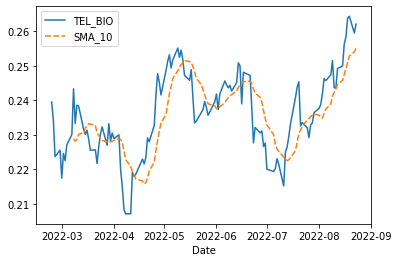

In [6]:
df = pd.read_csv('../../long_short_local/raw_data/cleaned_data.csv')
# convert 'Date' column to datetime values
df['Date'] = pd.to_datetime(df['Date'].str[:10])

test_df = df[['Date', 'TEL_BIO']]
sma10 = pd.DataFrame(ta.sma(test_df["TEL_BIO"], length=10))
tel_bio_df = pd.concat([test_df, sma10], axis=1, ignore_index=False)
tel_bio_df.set_index('Date', inplace=True)
sns.lineplot(data=tel_bio_df);

DO NOT CHANGE !

In [7]:
# convert 'Date' column to datetime values
df['Date'] = pd.to_datetime(df['Date'].str[:10])

AttributeError: Can only use .str accessor with string values!

In [ ]:
# split into 'train' and 'test' data
split_date = df['Date'][41]
df.set_index('Date', inplace=True)
train_df = df.loc[df.index <= split_date].copy()
test_df = df.loc[df.index > split_date].copy()

In [ ]:
def create_features(df, label=None):
    df['date'] = df.index
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.weekofyear

    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [ ]:
X_train, y_train = create_features(train_df, label='number')

In [ ]:
X_test, y_test = create_features(test_df, label='number')

In [ ]:
# build first model
model = XGBRegressor(n_estimators=1000)

In [ ]:
model.fit()